In [1]:
import deepxde as dde
import numpy as np
print("NumPy version:", np.__version__)
# Backend pytorch
import torch
import numpy as np
import datetime, os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


NumPy version: 2.1.3


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
    
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).squeeze()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]
# This function takes in a folder path with the DIB csv files and returns a list of dataframes with data
# from the CSV files
def getCSV(folder_path):
    files = []
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    for file in csv_files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(folder_path, file)
        dataframe = pd.read_csv(file_path, skiprows=range(15))
        files.append(dataframe)
    return files
#This function defines the Cottrell Equation which is Fick's second law of diffusion solved
# for specific boundary conditions for a planar electrode
def Cottrell_eq(t,n,D,F,A,i):
    return i/(n*F*A*(D**(1/2))/((np.pi**(1/2))*t**(1/2)))

def Nernst_eq(E,E0, n, F, R, T):
    #return U+((R*T/(n*F))*np.log((1-x)/x))+V_ni
    #return 1/(1+np.exp(-n*F*(E-E0)/(R*T))) #return x, concentration of reduced species
    return np.exp(E0-E)*(n*F/(R*T)) #return Q, [red]/[ox], = [li+][C6]/[LiC6] at anode

In [3]:
n = 1 #number of electrons transferred per ion
A = 1 #surface area of electrode
D = 2.5*10**(-6) #diffusion coefficient of LiPF6 in EC:DMC, cm^2/s
gas_const = 8.314 #gas constant
Temp = 25+273.15 #temperature
E0 = 3.7
# Problem parameter
c0 = 1.0 # initial concentration
D = 1.5*10**(-11) # solid-phase diffusion coefficient
R = 1.0
t = 1.0 # time 
It = 1.0 # current at time t
A = 1.0 # battery sheet area
L = 1.0 # thickness of positive/negative electrode
eps = 0.5 # solid phase volume fraction of each electrode
a = 3*eps/R # specific interfacial area
F = 96485 #Faraday's constant, C/mol
delta = It*R/(A*L*F*D*a*c0)

In [4]:
def pde(xyt, c):

    dc_x = dde.grad.jacobian(c, xyt, j=0)
    dc_t = dde.grad.jacobian(c, xyt, j=2)
    dc_xx = dde.grad.hessian(c, xyt, j=0)
    dc_yy = dde.grad.hessian(c, xyt, j=1)
    # Backend pytorch
    return (
        dc_t
        - 2 * dc_x / (xyt[:, 0] + 1e-6)
        + 0.025*(dc_xx+dc_yy)
    )

#def boundary_l(xt, on_boundary):
#    return on_boundary and dde.utils.isclose(xt[0], 0)

#def boundary_r(xt, on_boundary):
#    return on_boundary and dde.utils.isclose(xt[0], 1)

def boundary_x0(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_x1(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def boundary_y0(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0)

def boundary_y1(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1)

#def ic_x(x):
#    return 0

def boundary_y(x, on_boundary):
    return on_boundary and (dde.utils.isclose(x[1], 0) or dde.utils.isclose(x[1], 1))


Compiling model...
'compile' took 0.000139 s

Training model...

0         [2.84e+10, 9.66e-01, 1.44e-01, 1.35e-01, 2.47e-03]    [1.81e+10, 9.66e-01, 1.44e-01, 1.35e-01, 2.47e-03]    []  


1000      [3.64e+05, 4.53e-01, 1.05e-01, 1.24e-01, 1.40e-09]    [1.12e+05, 4.53e-01, 1.05e-01, 1.24e-01, 1.40e-09]    []  
2000      [1.65e+05, 4.53e-01, 1.05e-01, 1.22e-01, 5.84e-09]    [4.63e+04, 4.53e-01, 1.05e-01, 1.22e-01, 5.84e-09]    []  
3000      [8.18e+04, 4.51e-01, 1.06e-01, 1.20e-01, 2.87e-09]    [2.45e+04, 4.51e-01, 1.06e-01, 1.20e-01, 2.87e-09]    []  
4000      [4.00e+04, 4.49e-01, 1.07e-01, 1.18e-01, 5.51e-10]    [1.33e+04, 4.49e-01, 1.07e-01, 1.18e-01, 5.51e-10]    []  
5000      [1.89e+04, 4.47e-01, 1.08e-01, 1.16e-01, 5.01e-11]    [6.99e+03, 4.47e-01, 1.08e-01, 1.16e-01, 5.03e-11]    []  
6000      [8.23e+05, 4.47e-01, 1.10e-01, 1.16e-01, 7.91e-08]    [5.12e+05, 4.47e-01, 1.10e-01, 1.16e-01, 7.91e-08]    []  
7000      [7.63e+03, 4.46e-01, 1.09e-01, 1.14e-01, 1.76e-10]    [2.21e+03, 4.46e-01, 1.09e-01, 1.14e-01, 1.75e-10]    []  
8000      [6.28e+03, 4.45e-01, 1.10e-01, 1.13e-01, 2.15e-10]    [1.80e+03, 4.45e-01, 1.10e-01, 1.13e-01, 2.15e-10]    []  

Best model at s

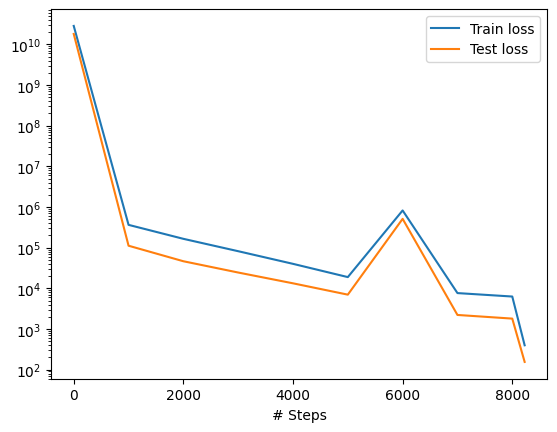

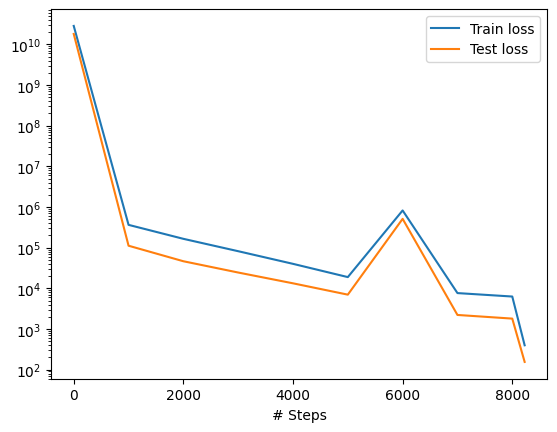

In [18]:
# Concentration from dataset
#n_obs = time0.shape
#observe_xt = np.vstack((np.ones(n_obs), np.array(time0))).T
#observe_c = li_conc0.reshape(-1,1)
#observe_pts = dde.icbc.PointSetBC(observe_xt, observe_c, component=0)
geom = dde.geometry.Rectangle([0, 0], [1, 1])


timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

#bc_l = dde.icbc.NeumannBC(geomtime, lambda X: 0.0, boundary_l)
#bc_r = dde.icbc.NeumannBC(geomtime, lambda X: 1.0, boundary_r)
bc_x0 = dde.icbc.DirichletBC(geomtime, lambda x: 1, boundary_x0)
bc_x1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_x1)

ic = dde.icbc.IC(geomtime, lambda t: 0, lambda _, on_initial: on_initial)


bc_y = dde.icbc.PeriodicBC(geomtime, 0, boundary_y)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_x0, bc_x1, ic, bc_y],
    num_domain=500,
    num_boundary=100,
    num_initial=100,
    #anchors=observe_xt,
    num_test=500,
)

layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

# Stage 1: Train with Adam optimizer for 8000 iterations
model.compile("adam", lr=0.001)
losshistory_adam, train_state_adam = model.train(iterations=8000)

# Stage 2: Train with L-BFGS optimizer for an additional 20000 iterations
# Recompiling the model preserves weights and states
model.compile("L-BFGS")
losshistory_lbfgs, train_state_lbfgs = model.train(iterations=1000)

# Save and plot the results
dde.saveplot(losshistory_adam, train_state_adam, issave=False, isplot=True)
dde.saveplot(losshistory_lbfgs, train_state_lbfgs, issave=False, isplot=True)

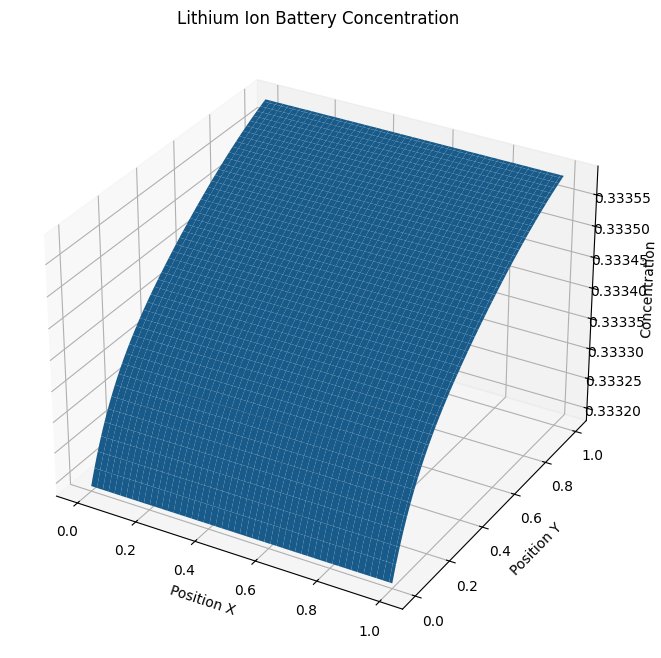

In [8]:
#%%
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

t = np.linspace(0, 1, 100)
X, Y, T = np.meshgrid(x, y, t)
X_2, Y_2= np.meshgrid(x, y)

X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
T_flat = T.flatten()[:, None]

points = np.hstack((X_flat, Y_flat, T_flat))
c_pred = model.predict(points)
C_pred = c_pred.reshape(X.shape)
C_pred_2 = C_pred[:,:,30]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_2, Y_2, C_pred_2)
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Concentration')
ax.set_title('Lithium Ion Battery Concentration')
plt.show()